In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5]

import numpy as np
import pandas as pd
import seaborn as sns
import statistics as stats
from tqdm import tqdm
import pdb
import copy

import sys
import os

#########################
# Experiment parameters #
#########################
from sklearn.base import clone
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

sys.path.append('../third_party')
sys.path.append('../methods')

## Data generation

In [2]:
from models import GaussianMixture, ConcentricCircles, ConcentricCircles2, ConcentricCirclesMixture, BinomialModel

random_state = 2023

model_name = "circles"

if model_name == "GaussianMixture":
    p = 20        # Number of features
    a = 0.25         # Signal amplitude
    model = GaussianMixture(p, a, random_state=random_state)
    purity = 0.8    # Proportion of inliers
    n = 1000          # Number of observations
    
elif model_name == "circles":
    p = 1000        # Number of features
    a = 0.4        # Signal amplitude
    model = ConcentricCirclesMixture(p, a, random_state=random_state)
    purity = 0.5      # Proportion of inliers
    n = 1000          # Number of observations

elif model_name == "BinomialModel":
    p = 100        # Number of features
    a = 5          # Signal amplitude
    model = BinomialModel(p, a, random_state=random_state)
    purity = 0.5     # Proportion of inliers
    n = 100          # Number of observations
    
else:
    print("Error: unknown model name!")
    
    
n_test = 10     # Number of test points
purity_test = 0.5 # Proportion of inliers in test set

X, Y = model.sample(n, purity)
X_test, Y_test = model.sample(n_test, purity)

print("Number of inliers in training/calibration data: {}.".format(np.sum(Y==0)))
print("Number of outliers in training/calibration data: {}.".format(np.sum(Y==1)))

print("Number of inliers in test data: {}.".format(np.sum(Y_test==0)))
print("Number of outliers in test data: {}.".format(np.sum(Y_test==1)))

Number of inliers in training/calibration data: 500.
Number of outliers in training/calibration data: 500.
Number of inliers in test data: 5.
Number of outliers in test data: 5.


## Define the integrative method

In [3]:
# Define list of possible one-class classifiers with desired hyper-parameters
bbox_occ_list = [svm.OneClassSVM(kernel='rbf', gamma="auto"),
                 svm.OneClassSVM(kernel='sigmoid'),
                 svm.OneClassSVM(kernel='poly', degree=3),
                 IsolationForest(contamination = 'auto', random_state=random_state),
                 #LocalOutlierFactor(contamination='auto', novelty=True)
               ]

# Choose a one-class classifier algorithm
bbox_occ = bbox_occ_list[1]

Fitting a one-class classification model on 250 data points... done.
Fitting a one-class classification model on 250 data points... done.
Fitting a one-class classification model on 250 data points... done.
Fitting a one-class classification model on 250 data points... done.
Fitting a one-class classification model on 250 data points... done.
Fitting a one-class classification model on 250 data points... done.
Fitting a one-class classification model on 250 data points... done.
Fitting a one-class classification model on 250 data points... done.


100%|██████████| 10/10 [00:00<00:00, 350.08it/s]


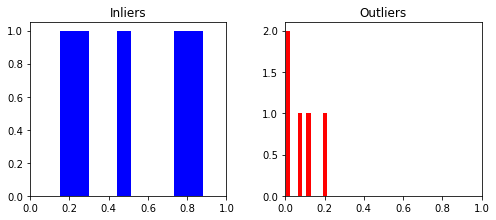

In [4]:
from methods_split import IntegrativeConformal

# Extract the inliers from the data
X_in = X[Y==0]
X_out = X[Y==1]

# Choose a family of one-class classifiers
bboxes_one = bbox_occ_list

# Compute the p-values
method_int = IntegrativeConformal(X_in, X_out, bboxes_one=bboxes_one, calib_size=0.5, tuning=True)
pvals_int = method_int.compute_pvalues(X_test, return_prepvals=False)

## Plot the p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0].hist(pvals_int[Y_test==0], color="blue")
axs[1].hist(pvals_int[Y_test==1], color="red")  
axs[0].title.set_text('Inliers')
axs[1].title.set_text('Outliers')
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
plt.show()

## Conditional FDR calibration

In [5]:
from methods_fdr import IntegrativeConformalFDR

alpha = 0.1

icfdr = IntegrativeConformalFDR(method_int)
rejection_sel, pruning_sel = icfdr.filter_fdr_conditional(X_test, alpha)
rejection_sel

100%|██████████| 10/10 [00:03<00:00,  2.81it/s]

Pruning is not needed.


array([0, 2])

## BH

In [6]:
rejection_bh = icfdr.filter_fdr_bh(X_test, alpha)
rejection_bh

100%|██████████| 10/10 [00:00<00:00, 385.44it/s]


array([0, 2])